In [1]:
import pycaret
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from uuid import uuid4

import numpy as np

from random import randint
import random

In [2]:
def return_list_of_csvs(root_path: Path, child_folder: str) -> list:
    """Retorna uma lista de arquivos csv de acordo com o caminho."""

    return list((root_path / child_folder).glob('**/*.csv'))


def extract_features(dframe: pd.DataFrame, label: int) -> pd.DataFrame:
    """Extrai a temperatura do módulo, radiação, a média da tensão e a média da corrente do dataframe.
    A label indica se a série é limpa (0) ou suja (1).

    Args:
        dframe (pd.DataFrame): DataFrame dos dados.
        label (int): Rótulo da série temporal.

    Returns:
        pd.DataFrame: _description_
    """

    temp_modulo = dframe.at[0, 'tempModulo']
    irrad = dframe.at[0, 'irrad']
    tensao_mean = dframe['tensao'].mean()
    corrente_mean = dframe['corrente'].mean()

    return (temp_modulo, irrad, tensao_mean, corrente_mean, label)

# Leitura dos Dados

In [3]:
ensaio_1 = Path('./data/ensaios/Ensaio 1 - Sem sombreamento/')
ensaio_2 = Path('./data/ensaios/Ensaio 2 - Fileiras de células sombreadas')
ensaio_3 = Path('./data/ensaios/Ensaio 3 - Colunas de células sombreadas/')
ensaio_4 = Path('./data/ensaios/Ensaio 4 - Uma célula sombreada por módulo/')
ensaio_5 = Path('./data/ensaios/Ensaio 5 - Duas células sombreadas por módulo/')
ensaio_6 = Path('./data/ensaios/Ensaio 6 - Sombreamento parcial de duas células por módulo/')

In [4]:
ensaio_1_limpa = return_list_of_csvs(ensaio_1, child_folder='Série FV limpa')
ensaio_1_suja = return_list_of_csvs(ensaio_1, child_folder='Série FV suja')

ensaio_2_limpa = return_list_of_csvs(ensaio_2, child_folder='Série FV limpa')
ensaio_2_suja = return_list_of_csvs(ensaio_2, child_folder='Série FV suja')

ensaio_3_limpa = return_list_of_csvs(ensaio_3, child_folder='Série FV limpa')
ensaio_3_suja = return_list_of_csvs(ensaio_3, child_folder='Série FV suja')

ensaio_4_limpa = return_list_of_csvs(ensaio_4, child_folder='Série FV limpa')
ensaio_4_suja = return_list_of_csvs(ensaio_4, child_folder='Série FV suja')

ensaio_5_limpa = return_list_of_csvs(ensaio_5, child_folder='Série FV limpa')
ensaio_5_suja = return_list_of_csvs(ensaio_5, child_folder='Série FV suja')

ensaio_6_limpa = return_list_of_csvs(ensaio_6, child_folder='Série FV limpa')
ensaio_6_suja = return_list_of_csvs(ensaio_6, child_folder='Série FV suja')


In [5]:
ensaios = {
    'limpa': [ensaio_1_limpa, ensaio_2_limpa, ensaio_3_limpa, ensaio_4_limpa, ensaio_5_limpa, ensaio_6_limpa],
    'suja': [ensaio_1_suja, ensaio_2_suja, ensaio_3_suja, ensaio_4_suja, ensaio_5_suja, ensaio_6_suja]
}

In [6]:
dfs_limpa = [pd.read_csv(file) for ensaio in ensaios.get('limpa') for file in ensaio]
dfs_suja = [pd.read_csv(file) for ensaio in ensaios.get('suja') for file in ensaio]

In [7]:
def get_irrad_bin(irrad: float) -> int:
    
    if 400 <= irrad < 500:
        return 0
    elif 500 <= irrad < 600:
        return 1
    elif 600 <= irrad < 700:
        return 2
    elif 700 <= irrad < 800:
        return 3
    elif 800 <= irrad < 900:
        return 4
    elif 900 <= irrad < 1000:
        return 5
    elif 1000 <= irrad < 1100:
        return 6
    

def extract_time_series(dff: pd.DataFrame, target: int, id_: str) -> pd.DataFrame:

    irrad = dff.at[0, 'irrad']

    dff = dff.drop(0)

    dff['target'] = target
    dff['id'] = id_
    dff['tmstmp'] = np.arange(0, 499, 1)
    dff['irrad_bin'] = get_irrad_bin(irrad)
    
    dff = dff.drop(columns=['tempModulo', 'irrad'])

    return dff #, temp, irrad

def extract_means(dff, target) -> pd.DataFrame:

    temp = dff.at[0, 'tempModulo'] 
    irrad = dff.at[0, 'irrad']

    tensao = dff['tensao'].mean()
    corrente = dff['corrente'].mean()

    return temp, irrad, tensao, corrente, target

In [8]:
dataset_limpa = [extract_time_series(df, target=0, id_=uuid4().hex) for df in dfs_limpa]
dataset_suja = [extract_time_series(df, target=1, id_=uuid4().hex) for df in dfs_suja]

df = pd.concat(dataset_limpa + dataset_suja)

In [9]:
# ds_limpa_means = [extract_means(df, target=0) for df in dfs_limpa]
# ds_suja_means = [extract_means(df, target=1) for df in dfs_limpa]

# df2 = pd.DataFrame(
#     [extract_means(df, 0) for df in dfs_limpa] + [extract_means(df, 1) for df in dfs_limpa],
#     columns=['temp', 'irrad', 'tensao', 'corrente', 'label']
# )

# EDA

In [10]:
output_fig_path = Path('./figures/eda')

In [11]:
def resample_by_id(dff: pd.DataFrame, range_: int = 10) -> list:

    return [random.choice(dff.id.unique()) for _ in range(range_)]

## Curva IV

In [16]:
from tqdm.notebook import tqdm

In [17]:
def pick_color_for_target(target: int):

    if target == 0:

        return 'green'

    return 'red'

In [19]:
root_path_curvas_iv = Path('./figures/eda/curvas_iv')
root_path_curvas_iv.mkdir(parents=True, exist_ok=True)

def plot_curva_iv(dff: pd.DataFrame, output_path: Path, sample_id: str) -> None:

    fig = plt.figure(figsize=(8, 6))

    sns.lineplot(data=dff, x='tensao', y='corrente')

    plt.xlim([-5, 905])
    plt.ylim([-1, 12])

    plt.tight_layout()
    plt.savefig(output_path / f'{sample_id}.jpg')
    plt.close()

for irrad in sorted(df.irrad_bin.unique()):

    fig_path = root_path_curvas_iv / f'{irrad}'
    fig_path.mkdir(parents=True, exist_ok=True)

    fig = plt.figure(figsize=(8, 6))

    for id_ in tqdm(df.query('irrad_bin == @irrad').id.unique()):

        dff = df.query('id == @id_').copy()

        color = pick_color_for_target(dff.target.unique().item())

        if color == 'red': color = 'r'
        elif color == 'green': color = 'g'

        sns.lineplot(data=dff, x='tensao', y='corrente', color=color)

    plt.xlim([-5, 905])
    plt.ylim([-1, 12])

    plt.tight_layout()
    plt.savefig(fig_path / f'{id_}.jpg')
    plt.close()


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
[]
df['tensao'].cut()

## Séries Temporais Separando radiação por faixas

In [20]:
IRRAD_BIN = 7

In [29]:
dff = df.query('irrad_bin == @IRRAD_BIN').copy()

fig = plt.figure(figsize=(6, 4))

for id_ in dff.id.unique():

    to_plot = dff.query('id == @id_')

    target = to_plot['target'].unique().item()

    color=pick_color_for_target(target)
    
    plt.plot(to_plot['tmstmp'], to_plot['corrente'], color=color, alpha=0.5, linewidth=2.0)

plt.tight_layout()
# plt.show()
complete_output_path = output_fig_path / 'series_temporais' / 'por faixa'

complete_output_path.mkdir(exist_ok=True, parents=True)

plt.savefig(output_fig_path / 'series_temporais' / f'{IRRAD_BIN}.jpg')
plt.close()

## Análise das Séries Temporais

In [15]:
df.at[1, 'tensao']

1    0.0
1    0.0
1    0.0
1    0.0
1    0.0
    ... 
1    0.0
1    0.0
1    0.0
1    0.0
1    0.0
Name: tensao, Length: 280, dtype: float64

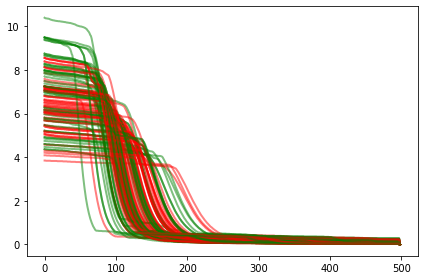

In [12]:
fig = plt.figure(figsize=(6, 4))

for id_ in resample_by_id(df, range_=120):

    to_plot = df.query('id == @id_')

    target = to_plot['target'].unique().item()

    color=pick_color(target)
    plt.plot(to_plot['tmstmp'], to_plot['corrente'], color=color, alpha=0.5, linewidth=2.0)

plt.tight_layout()
plt.show()
# plt.savefig(output_fig_path / 'series_temporais' / 'tensao.jpg')
plt.close()

## Distribuição de tensão e corrente por label

In [21]:
# Sample ids
ids = random.sample(df.id.unique().tolist(), 280)

df_sampled = df[df['id'].isin(ids)].reset_index(drop=True)

In [ ]:
sns.displot(
    data=df_sampled, 
    x='tensao',
    hue='target',
    kind='kde',
)

plt.title('Distribuição da Tensão')
plt.tight_layout()
# plt.savefig('tensao_sem_outliers.jpg')
plt.show()
plt.close()

In [ ]:
sns.displot(
    data=df_sampled.query('corrente > 1'), 
    x='corrente',
    hue='target',
    kind='kde',
)

plt.title('Distribuição da Corrente - Limitando Outliers')
plt.tight_layout()
plt.savefig('corrente_sem_outliers.jpg')
# plt.show()
plt.close()

<AxesSubplot:xlabel='corrente', ylabel='target'>

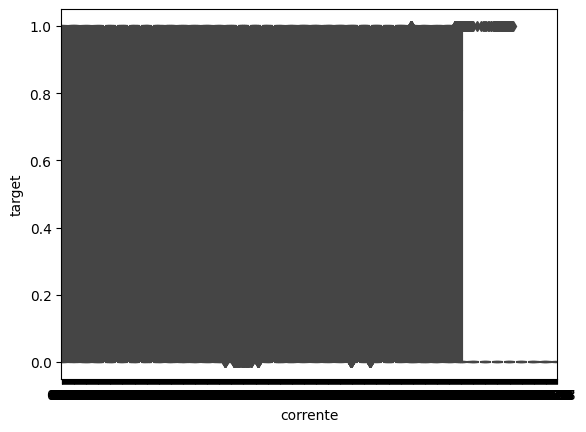

In [35]:
sns.boxplot(x=df['corrente'], y=df['target'])

# Análise Exploratória

In [ ]:
data.to_parquet('./dataset_teste.parquet')

In [ ]:
data.groupby('label').describe().T

In [ ]:
len(dataset_list)

In [ ]:
dataset_limpa[1]

In [ ]:
dataset_suja[5]